*This notebook is particularly designed for Youtube Academic Projects Series by Spartificial Innovations Pvt Ltd. However, anyone is allowed to use it, who is interested in understanding applications of Machine Learning through real world projects.*       
*Please contact team@spartificial.com or visit https://spartificial.com/ to know more.*         


# <center> Fish Species Detection & Recognition using Deep Learning

---

**Project ID: FSDR-1122**      

**Project Name: Fish Species Detection & Recognition using Deep Learning**

---

<center> <img src = "https://giffiles.alphacoders.com/202/20291.gif" width = 50%>

## Workflow of this notebook<a name ="h8"></a>
**1)** [Introducing the Problem](#h1)      
**2)** [Understanding the Dataset](#h2)    
**3)** [Importing necessary libraries and modules for this notebook](#h3)      
**4)** [Exploratory Analysis](#h4)           
**5)** [Image Generation & Preprocessing](#h5)   
**6)** [Model Training & Evaluation](#h6)        
**7)** [Tasks for You](#h7)

## Introduction to the Problem<a name ="h1"></a>

<p align="justify">Estimating the relative abundance of fish species in their habitats on a regular basis and keeping an eye on population fluctuations are crucial tasks for marine scientists and conservationists. Diverse automatic computer-based fish sample methods have been demonstrated in underwater photos and videos as alternatives to time-consuming hand sampling. There isn't, however, a perfect method for automatically detecting fish and classifying their species. This is mostly due to the difficulties in producing clear underwater images and videos, which include environmental fluctuations in lighting, fish camouflage, dynamic backdrops, murky water, low resolution, shape deformations of moving fish, and tiny variances between some fish species.

## Understanding the Dataset<a name ="h2"></a>

[This dataset](https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset) contains 9 different seafood types - These include gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout, shrimp image samples. For each class, there are 1000 augmented images and their pair-wise augmented ground truths. Each class can be found in the "Fish_Dataset" file with their ground truth labels. All images for each class are ordered from "00000.png" to "01000.png".


<p align="justify">For example, if you want to access the ground truth images of the shrimp in the dataset, the order should be followed is "Fish->Shrimp->Shrimp GT".

For the purpose of this analysis, we shall be using only the augmented images.
--


*Credits to this dataset -*

O.Ulucan, D.Karakaya, and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification.
In Conf. Innovations Intell. Syst. Appli. (ASYU)


## Importing necessary libraries and modules for this notebook<a name ="h3"></a>

In [1]:
'''Data Handling & Linear Algebra'''
import numpy as np
import pandas as pd
import os

'''Visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns

'''Manipulating Data and Model Building'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

'''Implementation of Transfer Learning'''
from tensorflow.keras.applications import MobileNetV2

'''Image generation and preprocessing'''
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

'''Result and Performance Analysis'''
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

'''Ignoring Warnings'''
import warnings
warnings.filterwarnings("ignore")

## Exploratory Analysis<a name ="h4"></a>

In [2]:
DIR = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' #Creating a master directory
classes = [i for i in os.listdir(DIR) if '.' not in i]                     #Creating classes out of the required folders
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [3]:
'''Since the GT images are of no use to us for the analysis, we will be separating them out of our directory'''

# Create a dataframe with a column which consists of all the filepaths (without GT) and its respective label as the other column

label = []
path = []

for dirname, _,filenames in os.walk(DIR):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dirname.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dirname)[-1])         # Append the directory name to label 
                path.append(os.path.join(dirname,filename))     # Append all the png files to path of that directory

# Ready to create the df
df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [4]:
df.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


In [5]:
df.path[0]

'/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png'

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [7]:
#Checking the value counts of each of the datasets
#df['label']=df['label'].astype('category')
df['label'].value_counts()

Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: label, dtype: int64

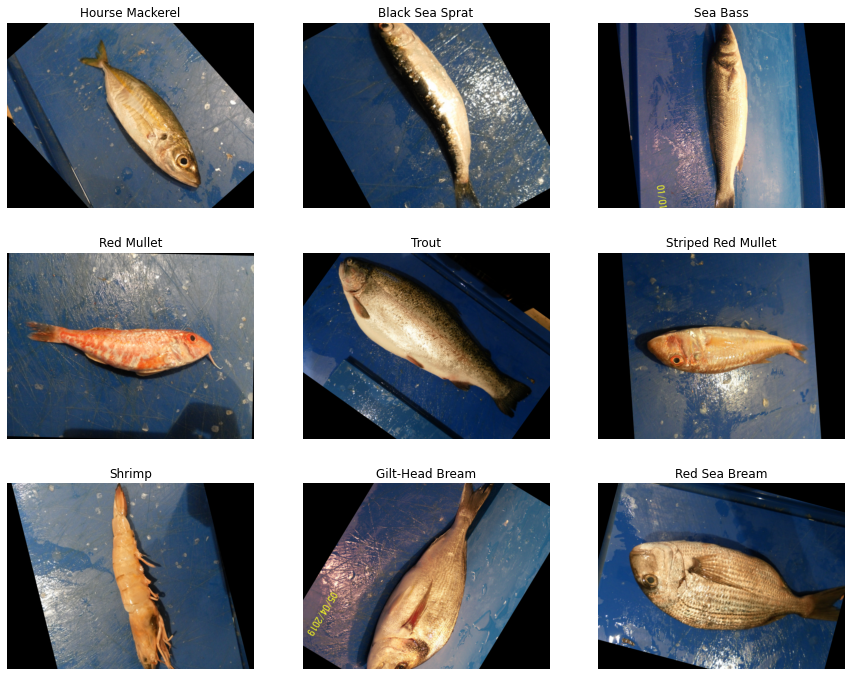

In [8]:
idx = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

## Test-Train Split

In [9]:
#Creating the test train split with shuffle
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [10]:
#Checking the shaoe of the newly obtained data
print(train_df.shape)
print(test_df.shape)

(7200, 2)
(1800, 2)


## Image Generation and Preprocessing<a name ="h5"></a>

In [11]:
#Using Keras Image Data Generator to preprocess our images with the model we wish to use
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False )

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [13]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

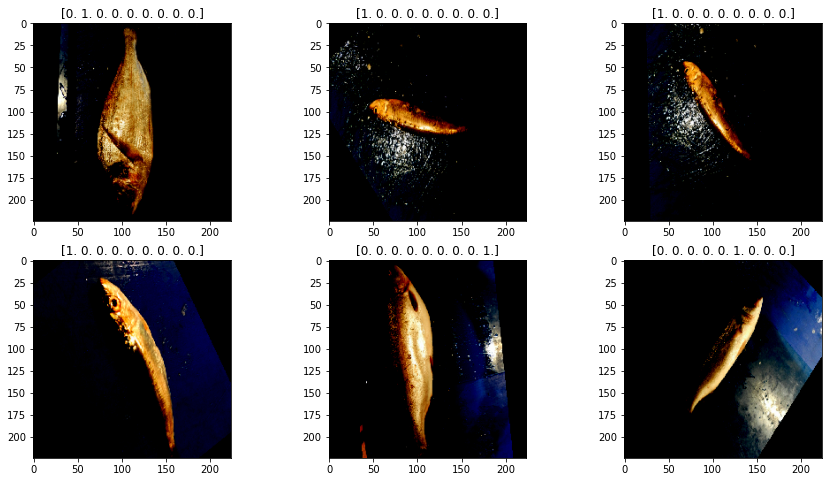

In [14]:
#Plotting images after pre-processing

fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = test_images.next()
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0])
    j=j+1

## Model Training and Evaluation<a name ="h6"></a>

## MobileNet v2 Architecture -
<center> <img src = "https://1.bp.blogspot.com/-M8UvZJWNW4E/WsKk-tbzp8I/AAAAAAAAChw/OqxBVPbDygMIQWGug4ZnHNDvuyK5FBMcQCLcBGAs/s1600/image5.png" width = 60%></center>

<p align="justify">MobileNetV2 is a convolutional neural network architecture that seeks to perform well on mobile devices. It is based on an inverted residual structure where the residual connections are between the bottleneck layers. The intermediate expansion layer uses lightweight depthwise convolutions to filter features as a source of non-linearity. As a whole, the architecture of MobileNetV2 contains the initial fully convolution layer with 32 filters, followed by 19 residual bottleneck layers.


In [15]:
#Importing our pretrained model : MobileNetV2

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

2023-02-06 14:20:56.616915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 14:20:56.723187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 14:20:56.723979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 14:20:56.725106: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [16]:
#Creating our model inputs
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

2023-02-06 14:21:01.083704: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2023-02-06 14:21:05.391342: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


180/180 [==============================] - 131s 679ms/step - loss: 0.1823 - accuracy: 0.9519 - val_loss: 0.0385 - val_accuracy: 0.9875
Epoch 2/5
180/180 [==============================] - 72s 399ms/step - loss: 0.0108 - accuracy: 0.9965 - val_loss: 0.0114 - val_accuracy: 0.9965
Epoch 3/5
180/180 [==============================] - 72s 402ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.9986
Epoch 4/5
180/180 [==============================] - 73s 403ms/step - loss: 8.6534e-04 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 0.9979
Epoch 5/5
180/180 [==============================] - 73s 407ms/step - loss: 4.7585e-04 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 0.9979


In [17]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.00398
Test Accuracy: 99.94%


In [18]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

In [19]:
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [35]:
# Visualize the pred_df
pred_df=pred_df.reset_index(drop=True)
pred_df.head(10)

,path,label,pred
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Gilt-Head Bream,Gilt-Head Bream
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Black Sea Sprat,Black Sea Sprat
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Trout,Trout
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream,Red Sea Bream
5,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream,Red Sea Bream
6,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Striped Red Mullet,Striped Red Mullet
7,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream,Red Sea Bream
8,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Mullet,Red Mullet
9,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Trout,Trout


In [36]:
# Incorrect prediction
pred_df[pred_df['label']!=pred_df['pred']]

,path,label,pred
1604,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Striped Red Mullet,Shrimp


In [64]:
pred_df.path[1604]

'/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Striped Red Mullet/Striped Red Mullet/00293.png'

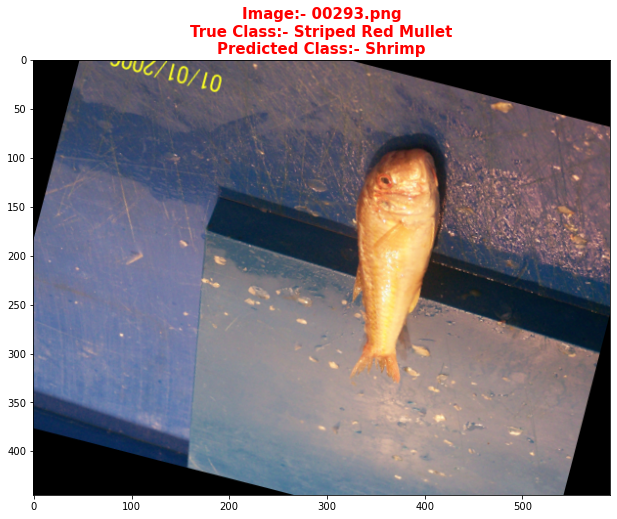

In [63]:
# Which image was it?
plt.figure(figsize=(15,8))
plt.imshow(plt.imread(pred_df.path[1604]))
title1 = pred_df.path[1604].split('/')[-2]
title2 = pred_df.path[1604].split('/')[-1]
title3 = pred_df.pred[1604]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
plt.show()

Accuracy Score: 0.9994444444444445


<AxesSubplot:>

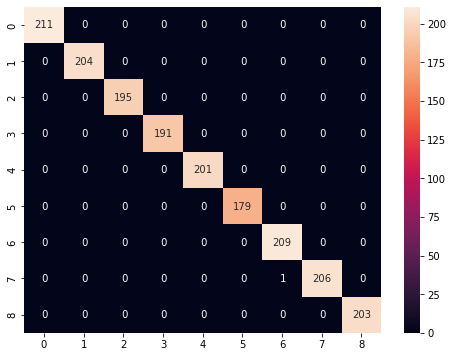

In [68]:
#Checking the accuracy score and creating a Confusion Matrix
print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')

In [69]:
#Generating the Classification Report for in-depth analysis
print(classification_report(pred_df['label'],pred_df['pred']))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       211
   Gilt-Head Bream       1.00      1.00      1.00       204
   Hourse Mackerel       1.00      1.00      1.00       195
        Red Mullet       1.00      1.00      1.00       191
     Red Sea Bream       1.00      1.00      1.00       201
          Sea Bass       1.00      1.00      1.00       179
            Shrimp       1.00      1.00      1.00       209
Striped Red Mullet       1.00      1.00      1.00       207
             Trout       1.00      1.00      1.00       203

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800



#### We have achieved an accuracy of 100%, which clearly demonstrates the power of transfer learning.



---

### References to learn more -
1. [A Comprehensive Hands-on Guide to Transfer Learning with Real-World Applications in Deep Learning - Towards Data Science](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)
2. [Introduction to Transfer Learning - Geeks for Geeks](https://www.geeksforgeeks.org/ml-introduction-to-transfer-learning/)
3. [Another example to classify images of cats and dogs by using transfer learning from a pre-trained network - Tensorflow](https://www.tensorflow.org/tutorials/images/transfer_learning)


## Task for you (Your chance to earn a certificate on completion!)<a name ="h7"></a> [Go to top ↑](#h8)

1. Implement the same problem statement using a different pre-trained model. You can have use [any of these](https://keras.io/api/applications/) or whichever other model you like. Alternatively, you can create your own CNN and observe the difference and effectiveness of Transfer Learning.

2. Try implementing image augmentation, change the number of epochs, the dense layers and neurons and compare your result with what we have done together in this project.

<b>Submit your solution notebook using [this](https://forms.gle/Yz4mm4Lq29zA1WhF9) form! All the Best!